<a href="https://colab.research.google.com/github/anikch/Anik424/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 14.4 MB/s 
     |████████████████████████████████| 182 kB 95.0 MB/s 
     |████████████████████████████████| 115 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 95.1 MB/s 
     |████████████████████████████████| 127 kB 94.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

## The Dataset Imported

Created by Fabbri et al. at 2019, **the Multi-News Dataset** consists of news articles and human-written summaries of these articles from the site newser.com. Each summary is professionally written by editors and includes links to the original articles cited., in English language. Containing 56,216 in SRC file format. For more info, [click here](https://paperswithcode.com/paper/multi-news-a-large-scale-multi-document).

In [ ]:
dataset = load_dataset("multi_news")
print(f"Features: {dataset['train'].column_names}")

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Dataset multi_news downloaded and prepared to /root/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['document', 'summary']


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

The dataset has two columns: document which contains the news articles and summary with the summaries.

In [ ]:
sample = dataset["train"][1]
print(f"""Document (excerpt of 2000 characters, total length: {len(sample["document"])}):""")
print(sample["document"][:2000])
print(f'\nSummary (length: {len(sample["summary"])}):')
print(sample["summary"])

Document (excerpt of 2000 characters, total length: 5353):
LOS ANGELES (AP) — In her first interview since the NBA banned her estranged husband, Shelly Sterling says she will fight to keep her share of the Los Angeles Clippers and plans one day to divorce Donald Sterling. 
 
 (Click Prev or Next to continue viewing images.) 
 
 ADVERTISEMENT (Click Prev or Next to continue viewing images.) 
 
 Los Angeles Clippers co-owner Shelly Sterling, below, watches the Clippers play the Oklahoma City Thunder along with her attorney, Pierce O'Donnell, in the first half of Game 3 of the Western Conference... (Associated Press) 
 
 Shelly Sterling spoke to Barbara Walters, and ABC News posted a short story with excerpts from the conversation Sunday. 
 
 NBA Commissioner Adam Silver has banned Donald Sterling for making racist comments and urged owners to force Sterling to sell the team. Silver added that no decisions had been made about the rest of Sterling's family. 
 
 According to ABC's story, Sh

We see that the document can be very long compared to the target summary. Long document pose a challenge to most transformer models since the context size is usually limited to 1,000 tokens or so, which is equivalent few paragraphs of text. The standard way to deal with this for summarization is to simply truncate the texts beyond the model's context size.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training a custom summarization model

### 1. Importing BART model for Fine-Tuning

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.0 MB/s 
     |████████████████████████████████| 7.6 MB 78.7 MB/s 


In [ ]:
from transformers import BartForConditionalGeneration, AutoTokenizer

model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460M [00:00<?, ?B/s]

### 2. Understanding the length distribution of the input and outputs

Before we process the data for training, let’s have a quick look at the length distribution of the input and outputs:

In [ ]:
%%time
d_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["document"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (2331 > 1024). Running this sequence through the model will result in indexing errors


CPU times: user 35.1 s, sys: 1.35 s, total: 36.5 s
Wall time: 36.3 s


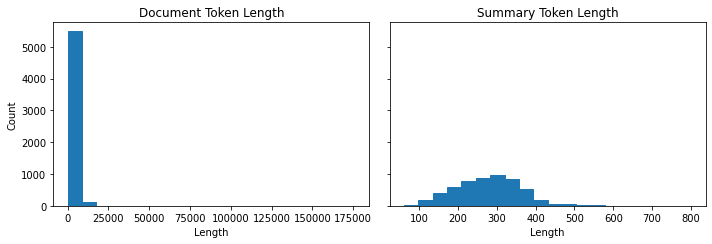

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Document Token Length")
axes[0].set_xlabel("Length")

axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

### 3. Converting datasets to features

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)
        
    return {"input_ids": input_encodings["input_ids"], 
           "attention_mask": input_encodings["attention_mask"], 
           "labels": target_encodings["input_ids"]}

dataset_tf = dataset.map(convert_examples_to_features, batched=True)

  0%|          | 0/45 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_tf.set_format(type="torch", columns=columns)

A new thing in the use of the tokenization step is the *tokenizer.as_target_tokenizer()* context. Some models require special tokens in the decoder inputs, so it’s important to differentiate between the tokenization of encoder and decoder inputs. In the with statement (called a *context manager*), the tokenizer knows that it is tokenizing for the decoder and can process sequences accordingly.

Now, we need to create the data collator. This function is called in the *Trainer* just before the batch is fed through the model. In most cases we can use the default collator, which collects all the tensors from the batch and simply stacks them. For the summarization task we need to not only stack the inputs but also prepare the targets on the decoder side. PEGASUS is an encoder-decoder transformer and thus has the classic *seq2seq* architecture. In a seq2seq setup, a common approach is to apply “teacher forcing” in the decoder. With this strategy, the decoder receives input tokens (like in decoder-only models such as GPT-2) that consists of the labels shifted by one in addition to the encoder output; so, when making the prediction for the next token the decoder gets the ground truth shifted by one as an input.

### 3. Using Data Collator
So, when we prepare our batch, we set up the decoder inputs by shifting the labels to the right by one. After that, we make sure the padding tokens in the labels are ignored by the loss function by setting them to –100. We actually don’t have to do this manually, though, since the *DataCollatorForSeq2Seq* comes to the rescue and takes care of all these steps for us.

In [ ]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### 4. Training the model

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bart-multi-news/content/drive/MyDrive/text_sum', num_train_epochs= 10, warmup_steps=500, 
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1, 
                                  weight_decay=0.01, logging_steps=10, push_to_hub=False, 
                                  evaluation_strategy='steps', eval_steps=500, save_steps=1e6, 
                                  gradient_accumulation_steps= 24)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, 
                  data_collator=seq2seq_data_collator, 
                  train_dataset=dataset_tf["train"], 
                  eval_dataset=dataset_tf["validation"])

trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 44972
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 24
  Total optimization steps = 18730
  Number of trainable parameters = 229933056


Step,Training Loss,Validation Loss
500,2.632300,2.534510
1000,2.616700,2.461818
1500,2.448900,2.437088
2000,2.327400,2.428957
2500,2.301800,2.424228
3000,2.302600,2.424268
3500,2.322400,2.401978
4000,2.125600,2.418030
4500,2.203300,2.407307
5000,2.129000,2.401782


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5622
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5622
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running 

Step,Training Loss,Validation Loss
500,2.632300,2.534510
1000,2.616700,2.461818
1500,2.448900,2.437088
2000,2.327400,2.428957
2500,2.301800,2.424228
3000,2.302600,2.424268
3500,2.322400,2.401978
4000,2.125600,2.418030
4500,2.203300,2.407307
5000,2.129000,2.401782


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5622
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5622
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, document. If summary, document are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running 

TrainOutput(global_step=18730, training_loss=1.9925688300104747, metrics={'train_runtime': 42392.0906, 'train_samples_per_second': 10.609, 'train_steps_per_second': 0.442, 'total_flos': 4.54221736131158e+17, 'train_loss': 1.9925688300104747, 'epoch': 10.0})

In [24]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]

input_ids = tokenizer(sample_text, max_length=1024, truncation=True, 
                   padding='max_length', return_tensors='pt').to(device)
summaries = model.generate(input_ids=input_ids['input_ids'], 
                           attention_mask=input_ids['attention_mask'], 
                           max_length=256)

decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                      clean_up_tokenization_spaces=True) 
                    for s in summaries]

print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])

Document:

 
 
 
 UPDATE: 4/19/2001 Read Richard Metzger: How I, a married, middle-aged man, became an accidental spokesperson for gay rights overnight on Boing Boing 
 
 It’s time to clarify a few details about the controversial “Hey Facebook what’s SO wrong with a pic of two men kissing?” story, as it now beginning to be reported in the mainstream media, and not always correctly. 
 
 First of all, with regards to the picture: 
 
 The photo which was used to illustrate my first post about the John Snow Kiss-In is a promotional still from the British soap opera “Eastenders.” It features one of the main characters from the show (Christian Clarke, played by the actor John Partridge- left) and someone else who I don’t know. I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character. 
 
 This picture has itself caused scandal in the UK, as it was a gay kiss that was broadcast before the watershed, and as such led to a number of complaints to the BBC

In [26]:
trainer.save_model('/content/bart-multi-news/saved_model')

Saving model checkpoint to /content/bart-multi-news/saved_model
Configuration saved in /content/bart-multi-news/saved_model/config.json
Model weights saved in /content/bart-multi-news/saved_model/pytorch_model.bin
tokenizer config file saved in /content/bart-multi-news/saved_model/tokenizer_config.json
Special tokens file saved in /content/bart-multi-news/saved_model/special_tokens_map.json


In [27]:
model = BartForConditionalGeneration.from_pretrained('/content/bart-multi-news/saved_model')

loading configuration file /content/bart-multi-news/saved_model/config.json
Model config BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-6-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": true,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
   

In [33]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
device

device(type='cuda')

In [35]:
model = model.to(device)

In [47]:
inp='''amson was benched for the entire three-match T20I series. Captain Hardik Pandya called it an “unfortunate” case. He was however picked for the ODI series opener on Friday where he put up a decent knock and stitched a healthy 96-run stand with Shreyas Iyer, albeit in a losing cause. He was then dropped to make way for Deepak Hooda in the second game and add more bowling depth to the XI, a decision that left fans fuming. 
However, on Tuesday, the day before the 3rd ODI, Samson was spotted having a long conversation with head coach VVS Laxman after his net session. Samson was spotted quietly listening to what Laxman had to say about his batting. The legendary batter, who filled in for Rahul Dravid's role for the tour, had a conversation with Suryakumar Yadav as well during India's net session. 
'''

In [48]:
input_ids = tokenizer(inp, max_length=1024, truncation=True, 
                   padding='max_length', return_tensors='pt').to(device)
summaries = model.generate(input_ids=input_ids['input_ids'], 
                           attention_mask=input_ids['attention_mask'], 
                           max_length=256)

decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                      clean_up_tokenization_spaces=True) 
                    for s in summaries]

In [49]:
decoded_summaries 

['– Samson was benched for the entire three-match T20I series after scoring a decent 96-run run against Shreyas Iyer in the opener against India on Friday, but he was then dropped to make way for Deepak Hooda in the second game. Captain Hardik Pandya called it an “unfortunate” decision, but Samson, who bats for India, was seen having a chat with coach VVS Laxman the day before the third ODI, the Guardian reports. Samson was spotted quietly listening to what the coach had to say about batting.']

In [51]:
summaries = model.generate(input_ids=input_ids['input_ids'], 
                           attention_mask=input_ids['attention_mask'], 
                           max_length=60)

decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                      clean_up_tokenization_spaces=True) 
                    for s in summaries]

decoded_summaries

['– Samson was benched for the entire three-match T20I series after scoring a decent 96-run run against Shreyas Iyer in the opener against India on Friday, but he was then dropped to make way for Deepak Hooda in the second game. Captain Hard']